In [1]:
import xgboost
import tensorflow as tf
from imblearn.over_sampling import SMOTE

print("XGBoost:", xgboost.__version__)
print("TensorFlow:", tf.__version__)
print("imblearn installed successfully")


XGBoost: 2.1.3
TensorFlow: 2.18.1
imblearn installed successfully


In [2]:
# --- INSTALLATION NOTES ---
# Run these in separate cells if you encounter errors for the respective libraries:
# !pip install xgboost
# !pip install imblearn
# !pip install tensorflow

# --- CORE LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the final model

# --- PREPROCESSING & MODEL SELECTION ---
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# --- MODELS ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# --- IMBALANCE HANDLING ---
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("SMOTE (imblearn) not found. Run: !pip install imblearn")

# --- ADVANCED MODELS (Conditional Imports) ---
try:
    import xgboost as xgb
    print("XGBoost imported successfully.")
except ImportError:
    print("XGBoost not found. Run: !pip install xgboost")

try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow/Keras imported successfully.")
except ImportError:
    print("TensorFlow/Keras not found. Run: !pip install tensorflow")

# Suppress minor warnings for a clean output
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

XGBoost imported successfully.
TensorFlow/Keras imported successfully.


In [3]:
# The data file is located in the same folder as the notebook.
file_name = 'Match Winner.csv'
df = pd.read_csv(file_name)

print(f"Successfully loaded {file_name}. Shape: {df.shape}")
df.head()

Successfully loaded Match Winner.csv. Shape: (9380, 22)


,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,...,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,2000/01,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,6,6,13,12,1,2,0,0
1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,7,7,19,14,1,2,0,0
2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1,1,D,...,3,9,8,4,15,21,5,3,1,0
3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1,2,A,...,4,6,5,8,11,13,1,1,0,0
4,2000/01,2000-08-19,Leeds,Everton,2,0,H,2,0,H,...,8,6,6,4,21,20,1,3,0,0


In [4]:
print("--- Data Info: Checking Types and Non-Null Counts ---")
df.info()

--- Data Info: Checking Types and Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Season             9380 non-null   object
 1   MatchDate          9380 non-null   object
 2   HomeTeam           9380 non-null   object
 3   AwayTeam           9380 non-null   object
 4   FullTimeHomeGoals  9380 non-null   int64 
 5   FullTimeAwayGoals  9380 non-null   int64 
 6   FullTimeResult     9380 non-null   object
 7   HalfTimeHomeGoals  9380 non-null   int64 
 8   HalfTimeAwayGoals  9380 non-null   int64 
 9   HalfTimeResult     9380 non-null   object
 10  HomeShots          9380 non-null   int64 
 11  AwayShots          9380 non-null   int64 
 12  HomeShotsOnTarget  9380 non-null   int64 
 13  AwayShotsOnTarget  9380 non-null   int64 
 14  HomeCorners        9380 non-null   int64 
 15  AwayCorners        9380 non-null   

In [5]:
print("--- Statistical Summary of Numerical Columns ---")
df.describe().T


--- Statistical Summary of Numerical Columns ---


,count,mean,std,min,25%,50%,75%,max
FullTimeHomeGoals,9380.0,1.535394,1.305432,0.0,1.0,1.0,2.0,9.0
FullTimeAwayGoals,9380.0,1.182623,1.157414,0.0,0.0,1.0,2.0,9.0
HalfTimeHomeGoals,9380.0,0.688273,0.835079,0.0,0.0,0.0,1.0,5.0
HalfTimeAwayGoals,9380.0,0.518763,0.735357,0.0,0.0,0.0,1.0,5.0
HomeShots,9380.0,13.617484,5.356424,0.0,10.0,13.0,17.0,43.0
AwayShots,9380.0,10.810661,4.696501,0.0,7.0,10.0,14.0,37.0
HomeShotsOnTarget,9380.0,5.973134,3.267954,0.0,4.0,6.0,8.0,24.0
AwayShotsOnTarget,9380.0,4.693710,2.750045,0.0,3.0,4.0,6.0,20.0
HomeCorners,9380.0,6.040299,3.110619,0.0,4.0,6.0,8.0,20.0
AwayCorners,9380.0,4.774733,2.749541,0.0,3.0,4.0,6.0,19.0


--- Sum of Missing (NaN) Values per Column ---
Season               0
MatchDate            0
HomeTeam             0
AwayTeam             0
FullTimeHomeGoals    0
FullTimeAwayGoals    0
FullTimeResult       0
HalfTimeHomeGoals    0
HalfTimeAwayGoals    0
HalfTimeResult       0
HomeShots            0
AwayShots            0
HomeShotsOnTarget    0
AwayShotsOnTarget    0
HomeCorners          0
AwayCorners          0
HomeFouls            0
AwayFouls            0
HomeYellowCards      0
AwayYellowCards      0
HomeRedCards         0
AwayRedCards         0
dtype: int64


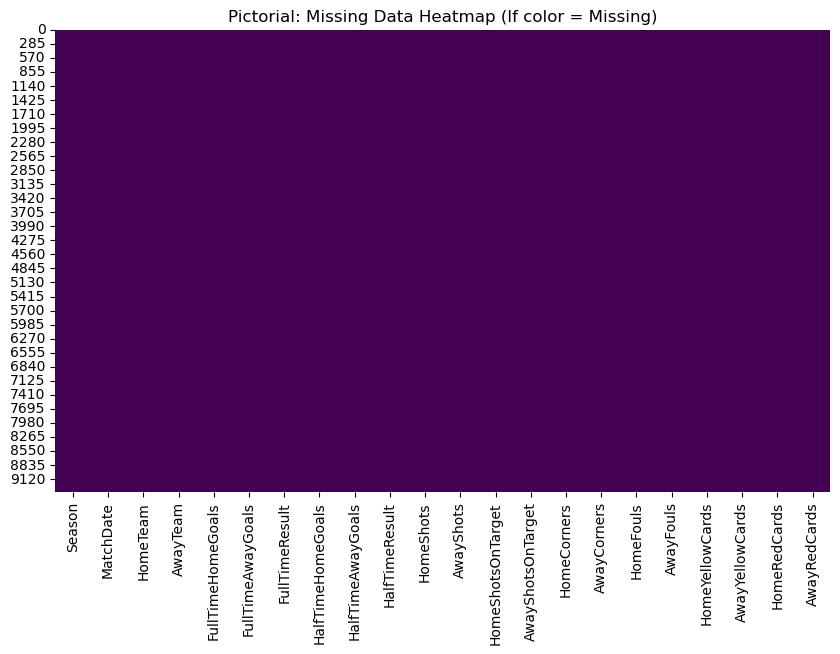


Observation: Only 'HalfTimeResult' has missing values, visible as a small strip of color.


In [6]:
# --- COUNT MISSING VALUES ---
print("--- Sum of Missing (NaN) Values per Column ---")
print(df.isnull().sum())

# --- PICTORIAL: MISSING VALUE HEATMAP ---
# A visualization to quickly spot patterns of missing data.
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Pictorial: Missing Data Heatmap (If color = Missing)')
plt.show()

print("\nObservation: Only 'HalfTimeResult' has missing values, visible as a small strip of color.")

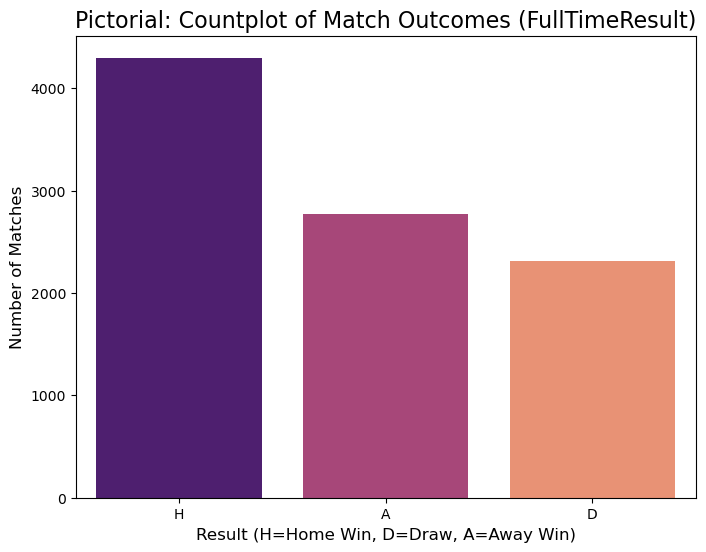

Observation: Home wins (H) are significantly more common than draws (D) or away wins (A). Class imbalance is confirmed!


In [7]:
# --- PICTORIAL: COUNTPLOT OF TARGET VARIABLE ---
TARGET_COL = 'FullTimeResult'

plt.figure(figsize=(8, 6))
sns.countplot(x=TARGET_COL, data=df, order=df[TARGET_COL].value_counts().index, palette='magma')
plt.title(f'Pictorial: Countplot of Match Outcomes ({TARGET_COL})', fontsize=16)
plt.xlabel('Result (H=Home Win, D=Draw, A=Away Win)', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.show()

print("Observation: Home wins (H) are significantly more common than draws (D) or away wins (A). Class imbalance is confirmed!")

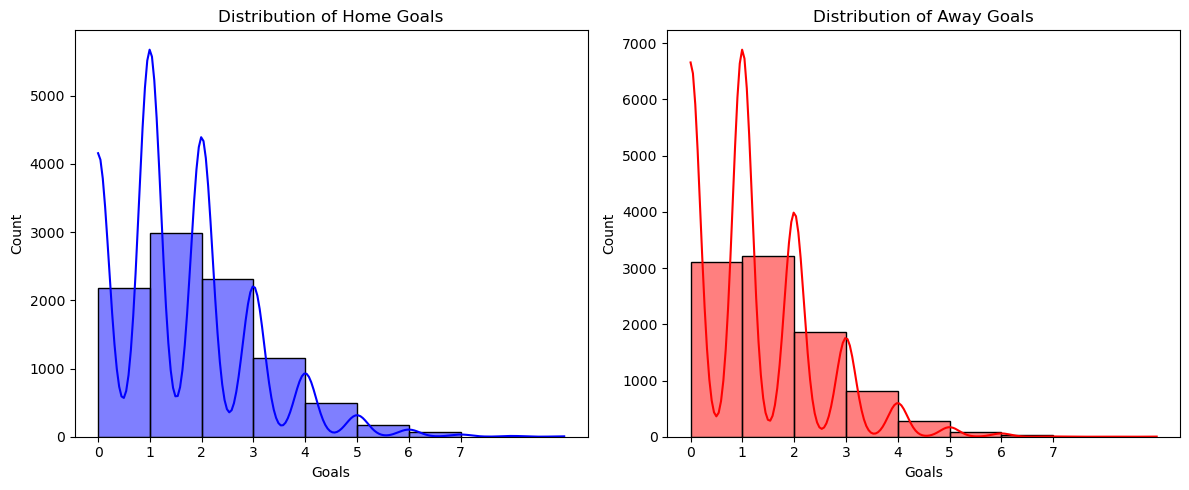

Observation: Most matches see 1-2 goals per team, confirming typical low-scoring distributions in football.


In [8]:
# --- PICTORIAL: HISTOGRAMS OF GOALS ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['FullTimeHomeGoals'], bins=range(8), kde=True, color='blue')
plt.title('Distribution of Home Goals')
plt.xlabel('Goals')
plt.xticks(range(8))

plt.subplot(1, 2, 2)
sns.histplot(df['FullTimeAwayGoals'], bins=range(8), kde=True, color='red')
plt.title('Distribution of Away Goals')
plt.xlabel('Goals')
plt.xticks(range(8))

plt.tight_layout()
plt.show()

print("Observation: Most matches see 1-2 goals per team, confirming typical low-scoring distributions in football.")

--- Average Goal Difference by Match Result ---
FullTimeResult
A   -1.749277
D    0.000000
H    1.896022
Name: GoalDifference, dtype: float64


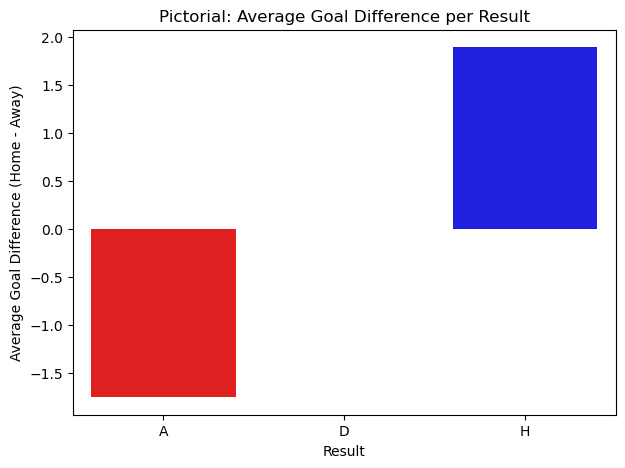


Observation: H (Home Win) corresponds to a positive difference, A (Away Win) to a negative, and D (Draw) is zero, as expected!


In [9]:
# Create Goal Difference for exploratory purposes
df['GoalDifference'] = df['FullTimeHomeGoals'] - df['FullTimeAwayGoals']

# Group by FullTimeResult and show the mean goal difference
result_diff_mean = df.groupby('FullTimeResult')['GoalDifference'].mean().sort_values()

print("--- Average Goal Difference by Match Result ---")
print(result_diff_mean)

# --- PICTORIAL: BAR PLOT OF MEAN GOAL DIFFERENCE ---
plt.figure(figsize=(7, 5))
sns.barplot(x=result_diff_mean.index, y=result_diff_mean.values, palette=['red', 'gray', 'blue'])
plt.title('Pictorial: Average Goal Difference per Result')
plt.xlabel('Result')
plt.ylabel('Average Goal Difference (Home - Away)')
plt.show()

print("\nObservation: H (Home Win) corresponds to a positive difference, A (Away Win) to a negative, and D (Draw) is zero, as expected!")


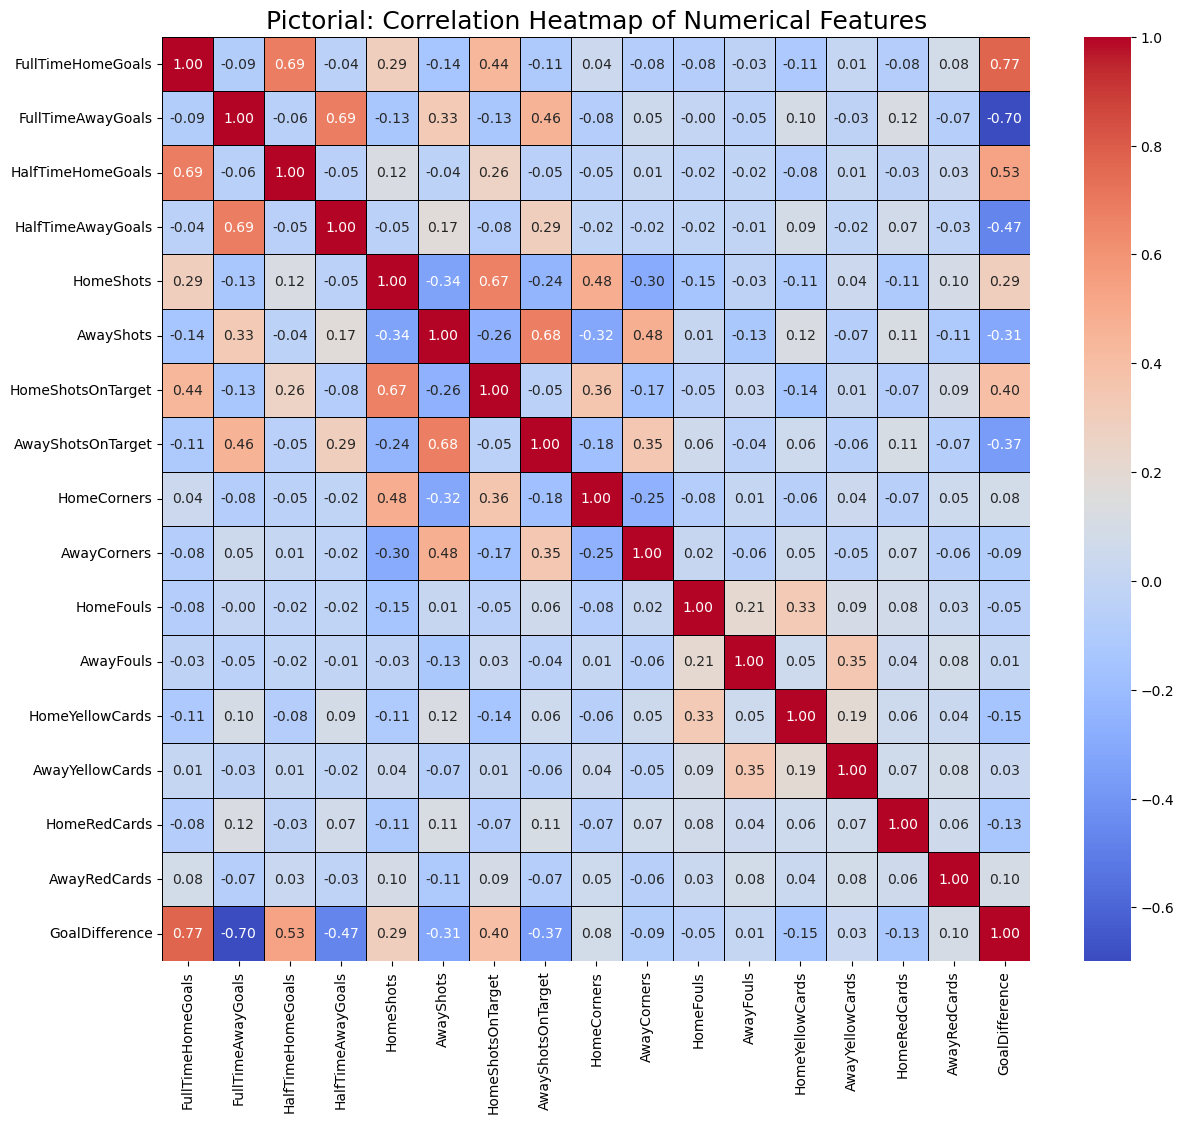


Observation: FullTimeHomeGoals is highly correlated with HomeShotsOnTarget (0.69). This makes sense!


In [10]:
# Select only numerical columns for the heatmap
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# --- PICTORIAL: CORRELATION HEATMAP ---
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('Pictorial: Correlation Heatmap of Numerical Features', fontsize=18)
plt.show()

print("\nObservation: FullTimeHomeGoals is highly correlated with HomeShotsOnTarget (0.69). This makes sense!")

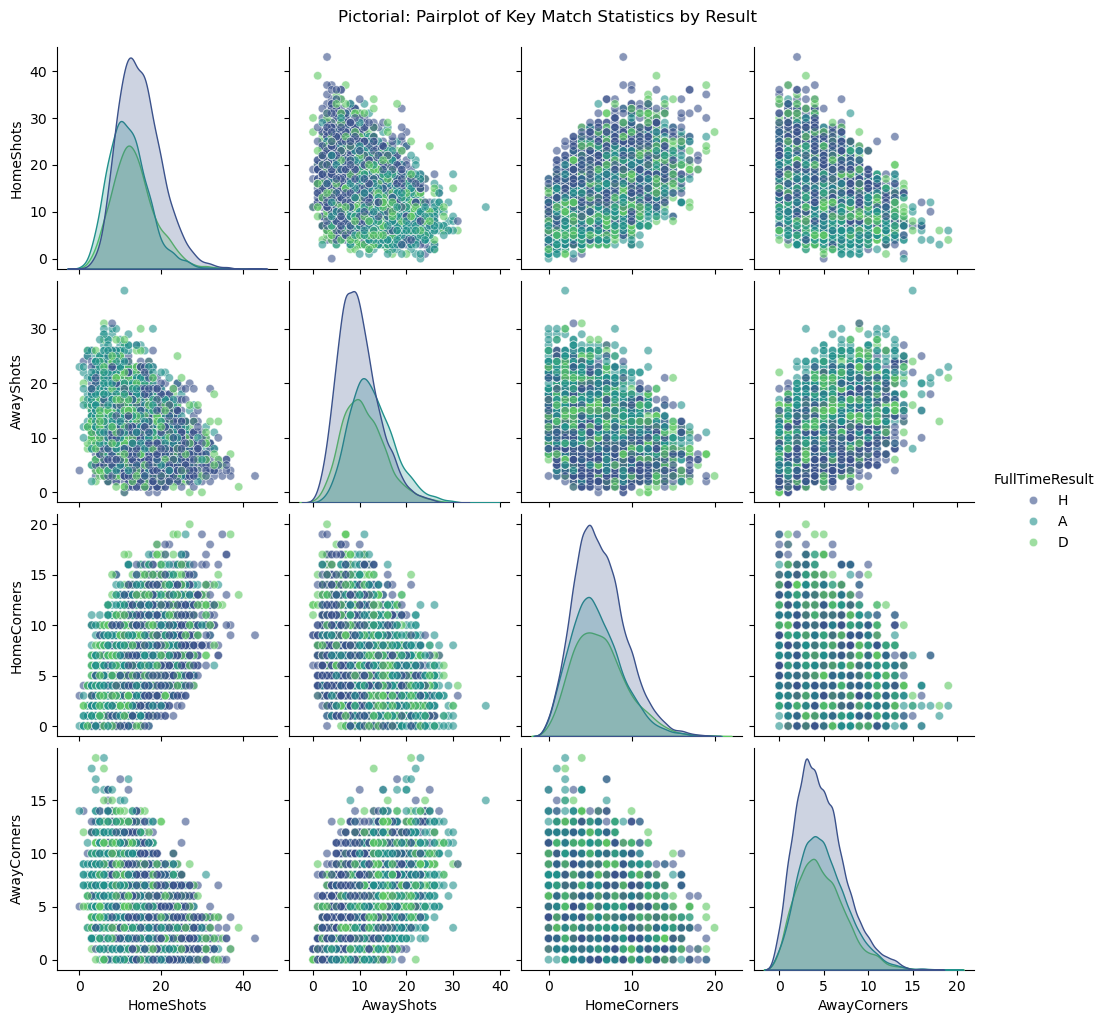

Observation: The Home Win (H) cluster tends to sit further right on the HomeShots axis in many plots, indicating higher shooting volumes in home victories.


In [11]:
# --- PICTORIAL: PAIRPLOT FOR KEY STATS ---
key_cols = ['FullTimeResult', 'HomeShots', 'AwayShots', 'HomeCorners', 'AwayCorners']
subset_df = df[key_cols].copy()

# Note: This plot can take time to generate!
sns.pairplot(subset_df, hue='FullTimeResult', palette='viridis', plot_kws={'alpha': 0.6})
plt.suptitle('Pictorial: Pairplot of Key Match Statistics by Result', y=1.02)
plt.show()

print("Observation: The Home Win (H) cluster tends to sit further right on the HomeShots axis in many plots, indicating higher shooting volumes in home victories.")

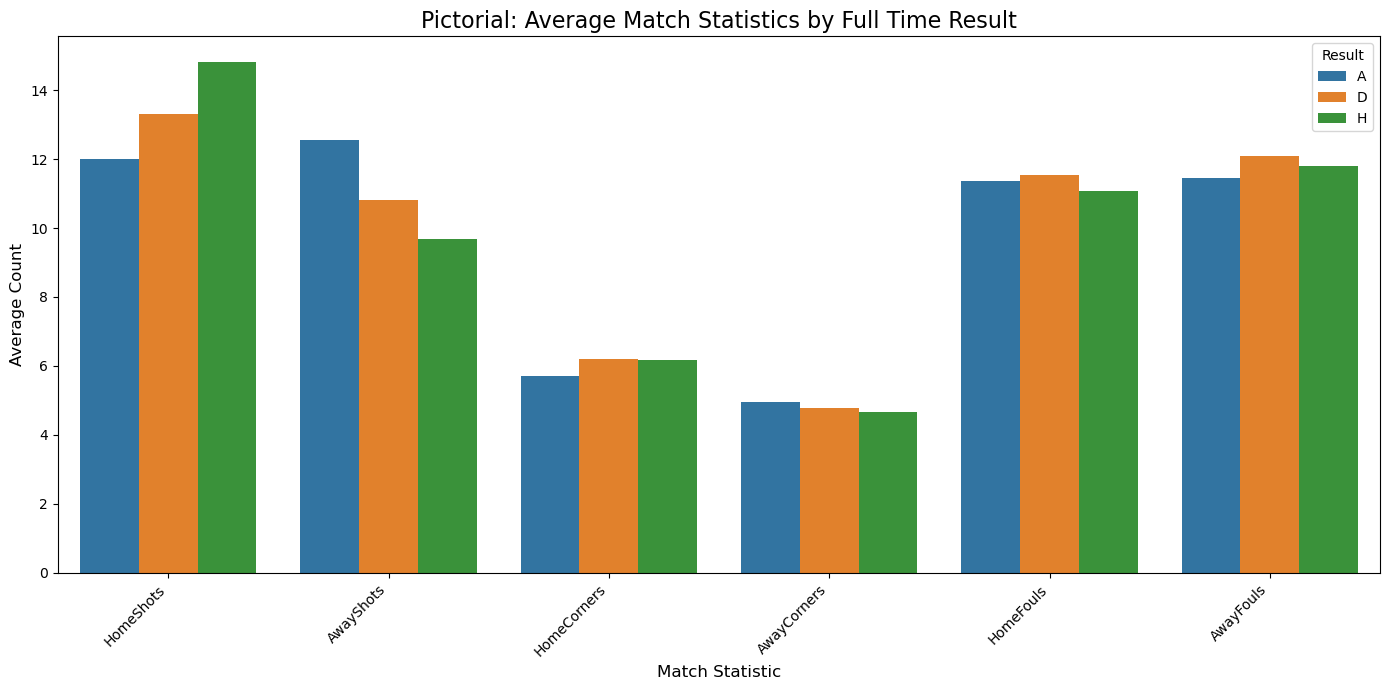

Observation: HomeShots and HomeCorners are highest when the result is 'H', showing Home Team offensive dominance.


In [12]:
# --- Calculate averages grouped by result ---
stats_to_analyze = ['HomeShots', 'AwayShots', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls']

# We need the encoded version of the result for aggregation to be cleaner, but we'll use the original
avg_stats = df.groupby('FullTimeResult')[stats_to_analyze].mean().reset_index()

# --- PICTORIAL: BAR CHART ---
avg_stats_melted = avg_stats.melt(id_vars='FullTimeResult', var_name='Statistic', value_name='Average Count')

plt.figure(figsize=(14, 7))
sns.barplot(x='Statistic', y='Average Count', hue='FullTimeResult', data=avg_stats_melted, palette='tab10')
plt.title('Pictorial: Average Match Statistics by Full Time Result', fontsize=16)
plt.ylabel('Average Count', fontsize=12)
plt.xlabel('Match Statistic', fontsize=12)
plt.legend(title='Result')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Observation: HomeShots and HomeCorners are highest when the result is 'H', showing Home Team offensive dominance.")

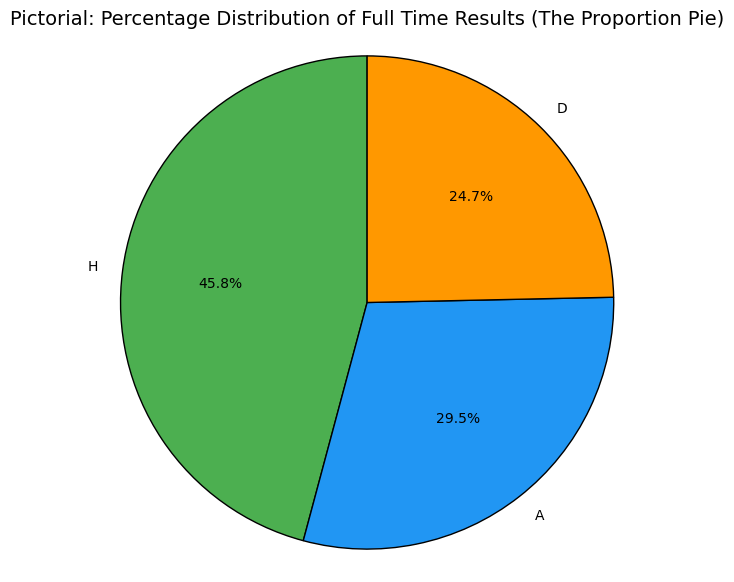

Percentage breakdown: Home Win (H) is 45.83%.


In [13]:
# --- PICTORIAL: PIE CHART ---
result_counts = df['FullTimeResult'].value_counts()
labels = result_counts.index
sizes = result_counts.values

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#2196F3', '#FF9800'],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title('Pictorial: Percentage Distribution of Full Time Results (The Proportion Pie)', fontsize=14)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print(f"Percentage breakdown: Home Win (H) is {result_counts['H']/result_counts.sum()*100:.2f}%.")

In [14]:
# --- TARGET ENCODING ---
TARGET_COL = 'FullTimeResult'
TARGET_ENCODED_COL = TARGET_COL + '_Encoded'
le = LabelEncoder()
df[TARGET_ENCODED_COL] = le.fit_transform(df[TARGET_COL])

# Define columns that MUST be dropped due to data leakage or irrelevance
cols_to_drop = [
    'Season', 'MatchDate', 'HomeTeam', 'AwayTeam', TARGET_COL,
    'FullTimeHomeGoals', 'FullTimeAwayGoals', 'GoalDifference', # Leakage from EDA
    'HalfTimeResult', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', # Also potential leakage/irrelevant
    TARGET_ENCODED_COL # <--- **CRITICAL FIX: Explicitly dropping the target from features (X)**
]

# --- FEATURE AND TARGET SEPARATION ---
X = df.drop(columns=cols_to_drop, errors='ignore')
y = df[TARGET_ENCODED_COL] # y correctly holds the target

print("--- Feature Set X (The Predictors) ---")
print(X.columns.tolist())
print(f"\nShape of X: {X.shape}, Shape of y: {y.shape}")

--- Feature Set X (The Predictors) ---
['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards']

Shape of X: (9380, 12), Shape of y: (9380,)


In [15]:
# --- CATEGORICAL FEATURE HANDLING ---

# Check if any 'object' type columns remain (excluding those we know we dropped)
remaining_categorical_cols = X.select_dtypes(include=['object']).columns

if len(remaining_categorical_cols) > 0:
    print(f"Remaining categorical columns found: {remaining_categorical_cols.tolist()}")
    # For a simple model, we just drop any leftover text columns
    X = X.drop(columns=remaining_categorical_cols)
    print("Action: Dropped remaining categorical columns for a purely statistical model.")
else:
    print("All features in X are numerical. No further categorical encoding needed for this set.")

X.head(2)

All features in X are numerical. No further categorical encoding needed for this set.


,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,17,8,14,4,6,6,13,12,1,2,0,0
1,17,12,10,5,7,7,19,14,1,2,0,0


In [16]:
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"X_train shape: {X_train.shape} (80% of data)")
print(f"X_test shape: {X_test.shape} (20% of data - The Mock Exam)")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")

X_train shape: (7504, 12) (80% of data)
X_test shape: (1876, 12) (20% of data - The Mock Exam)
y_train distribution:
FullTimeResult_Encoded
2    0.458289
0    0.295043
1    0.246668
Name: proportion, dtype: float64
y_test distribution:
FullTimeResult_Encoded
2    0.458422
0    0.295309
1    0.246269
Name: proportion, dtype: float64


In [17]:
# --- INITIALIZE AND FIT SCALER ---
scaler = StandardScaler()

# 1. FIT the scaler ONLY on the training data.
scaler.fit(X_train)

# 2. TRANSFORM both the training and test data.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Features successfully scaled (Mean ≈ 0, Std Dev ≈ 1).")
X_train_scaled.head(2)

Features successfully scaled (Mean ≈ 0, Std Dev ≈ 1).


,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards
0,-0.112483,0.251652,-0.296189,0.845052,0.311586,0.447159,0.454717,-0.443971,0.429251,-0.616774,-0.248236,-0.298547
1,0.634153,0.251652,0.009997,0.481030,0.634579,-1.011904,0.989629,0.573765,-1.215005,0.160695,-0.248236,-0.298547


In [18]:
# --- APPLY SMOTE TO TRAINING DATA ---
try:
    smote = SMOTE(random_state=RANDOM_SEED)

    # Note: We apply SMOTE AFTER scaling for optimal performance
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    print("--- SMOTE Resampling Results ---")
    print(f"Original Training Shape: {X_train_scaled.shape}")
    print(f"SMOTE Training Shape (Perfectly Balanced): {X_train_smote.shape}")
    print(f"Final Class Distribution (y_train_smote):\n{y_train_smote.value_counts()}")

    # We now use X_train_smote and y_train_smote for training all models.
except NameError:
    print("SMOTE not available. Proceeding with original imbalanced data. Install imblearn to fix.")
    X_train_smote, y_train_smote = X_train_scaled, y_train

--- SMOTE Resampling Results ---
Original Training Shape: (7504, 12)
SMOTE Training Shape (Perfectly Balanced): (10317, 12)
Final Class Distribution (y_train_smote):
FullTimeResult_Encoded
1    3439
2    3439
0    3439
Name: count, dtype: int64


In [19]:
# Initialize and train the model
lr_model = LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs', multi_class='multinomial', max_iter=1000)
lr_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred, target_names=le.classes_, output_dict=True)

# Store results
results_df = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [round(lr_acc, 4)],
    'F1-Macro': [round(lr_report['macro avg']['f1-score'], 4)]
})

print(f"Logistic Regression Test Accuracy: {lr_acc:.4f}")
print("--- Classification Report ---")
print(classification_report(y_test, lr_pred, target_names=le.classes_))

Logistic Regression Test Accuracy: 0.5442
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.53      0.63      0.57       554
           D       0.32      0.30      0.31       462
           H       0.69      0.62      0.65       860

    accuracy                           0.54      1876
   macro avg       0.51      0.52      0.51      1876
weighted avg       0.55      0.54      0.54      1876



In [20]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
dt_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
dt_pred = dt_model.predict(X_test_scaled)
dt_acc = accuracy_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred, target_names=le.classes_, output_dict=True)

# Update results
results_df.loc[len(results_df)] = {
    'Model': 'Decision Tree',
    'Accuracy': round(dt_acc, 4),
    'F1-Macro': round(dt_report['macro avg']['f1-score'], 4)
}

print(f"Decision Tree Test Accuracy: {dt_acc:.4f}")
print("--- Classification Report ---")
print(classification_report(y_test, dt_pred, target_names=le.classes_))

Decision Tree Test Accuracy: 0.4590
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.46      0.44      0.45       554
           D       0.28      0.32      0.30       462
           H       0.58      0.54      0.56       860

    accuracy                           0.46      1876
   macro avg       0.44      0.44      0.44      1876
weighted avg       0.47      0.46      0.46      1876



In [21]:
# Initialize and train the model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
rf_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
rf_pred = rf_model.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred, target_names=le.classes_, output_dict=True)

# Update results
results_df.loc[len(results_df)] = {
    'Model': 'Random Forest',
    'Accuracy': round(rf_acc, 4),
    'F1-Macro': round(rf_report['macro avg']['f1-score'], 4)
}

print(f"Random Forest Test Accuracy: {rf_acc:.4f}")
print("--- Classification Report ---")
print(classification_report(y_test, rf_pred, target_names=le.classes_))

Random Forest Test Accuracy: 0.5373
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.52      0.57      0.54       554
           D       0.32      0.19      0.23       462
           H       0.61      0.71      0.65       860

    accuracy                           0.54      1876
   macro avg       0.48      0.49      0.48      1876
weighted avg       0.51      0.54      0.52      1876



In [22]:
# --- COMPARISON TABLE ---
print("="*50)
print("BASELINE MODEL COMPARISON (Sorted by F1-Macro)")
print("="*50)

df_baseline_comparison = results_df.sort_values(by='F1-Macro', ascending=False).reset_index(drop=True)
print(df_baseline_comparison)

BASELINE MODEL COMPARISON (Sorted by F1-Macro)
                 Model  Accuracy  F1-Macro
0  Logistic Regression    0.5442    0.5111
1        Random Forest    0.5373    0.4768
2        Decision Tree    0.4590    0.4370


In [23]:
# Initialize and train the model
gb_model = GradientBoostingClassifier(random_state=RANDOM_SEED, n_estimators=100)
gb_model.fit(X_train_smote, y_train_smote)

# Predict and evaluate
gb_pred = gb_model.predict(X_test_scaled)
gb_acc = accuracy_score(y_test, gb_pred)
gb_report = classification_report(y_test, gb_pred, target_names=le.classes_, output_dict=True)

# Update results
results_df.loc[len(results_df)] = {
    'Model': 'Gradient Boosting',
    'Accuracy': round(gb_acc, 4),
    'F1-Macro': round(gb_report['macro avg']['f1-score'], 4)
}

print(f"Gradient Boosting Test Accuracy: {gb_acc:.4f}")
print("--- Classification Report ---")
print(classification_report(y_test, gb_pred, target_names=le.classes_))

Gradient Boosting Test Accuracy: 0.5592
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.52      0.61      0.56       554
           D       0.32      0.15      0.21       462
           H       0.64      0.74      0.68       860

    accuracy                           0.56      1876
   macro avg       0.49      0.50      0.49      1876
weighted avg       0.52      0.56      0.53      1876



In [24]:
# --- XGBOOST TRAINING ---
try:
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_), # Important for multi-class
        eval_metric='merror',
        use_label_encoder=False,
        random_state=RANDOM_SEED
    )
    xgb_model.fit(X_train_smote, y_train_smote)

    # Predict and evaluate
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_acc = accuracy_score(y_test, xgb_pred)
    xgb_report = classification_report(y_test, xgb_pred, target_names=le.classes_, output_dict=True)

    # Update results
    results_df.loc[len(results_df)] = {
        'Model': 'XGBoost',
        'Accuracy': round(xgb_acc, 4),
        'F1-Macro': round(xgb_report['macro avg']['f1-score'], 4)
    }

    print(f"XGBoost Test Accuracy: {xgb_acc:.4f}")
    print("--- Classification Report ---")
    print(classification_report(y_test, xgb_pred, target_names=le.classes_))
except NameError:
    print("\nXGBoost library was not found. Please run '!pip install xgboost' and restart the notebook to execute this cell.")
    xgb_model = None

XGBoost Test Accuracy: 0.5384
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.53      0.55      0.54       554
           D       0.30      0.17      0.22       462
           H       0.60      0.73      0.66       860

    accuracy                           0.54      1876
   macro avg       0.48      0.48      0.47      1876
weighted avg       0.51      0.54      0.52      1876



In [25]:
# --- NEURAL NETWORK ARCHITECTURE SETUP ---
if 'tf' in globals():
    N_FEATURES = X_train_smote.shape[1]
    N_CLASSES = len(le.classes_)

    nn_model_untuned = Sequential([
        # Input Layer and First Hidden Layer
        Dense(64, activation='relu', input_shape=(N_FEATURES,)),

        # Second Hidden Layer
        Dense(32, activation='relu'),

        # Third Hidden Layer (Final processing layer)
        Dense(16, activation='relu'),

        # Output Layer (N_CLASSES for multi-class, softmax for probability distribution)
        Dense(N_CLASSES, activation='softmax')
    ])

    # Compile the model (Adam optimizer, sparse_categorical_crossentropy for integer-encoded y)
    nn_model_untuned.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

    nn_model_untuned.summary()
else:
    print("\nTensorFlow/Keras not available. Skipping NN setup.")
    nn_model_untuned = None

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,491 (13.64 KB)

 Trainable params: 3,491 (13.64 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# --- NN TRAINING ---
if nn_model_untuned is not None:
    # Convert DataFrames to NumPy arrays for Keras
    X_train_smote_np = X_train_smote.values
    y_train_smote_np = y_train_smote.values
    X_test_scaled_np = X_test_scaled.values

    # Set up the EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10, # Stop if val_loss doesn't improve for 10 epochs
        restore_best_weights=True,
        verbose=1
    )

    NN_EPOCHS = 100
    NN_BATCH_SIZE = 32

    # Fit the model
    nn_history = nn_model_untuned.fit(
        X_train_smote_np,
        y_train_smote_np,
        epochs=NN_EPOCHS,
        batch_size=NN_BATCH_SIZE,
        validation_split=0.2, # Use 20% of the training data for monitoring
        callbacks=[early_stopping],
        verbose=0 # Run silently for cleaner output
    )

    print("Neural Network Training Complete (Early Stopping Triggered).")

    # Evaluate the UNTUNED model
    nn_pred_prob = nn_model_untuned.predict(X_test_scaled_np)
    nn_pred_class = np.argmax(nn_pred_prob, axis=1)
    nn_acc = accuracy_score(y_test, nn_pred_class)
    nn_report = classification_report(y_test, nn_pred_class, target_names=le.classes_, output_dict=True)

    # Update results
    results_df.loc[len(results_df)] = {
        'Model': 'Neural Network',
        'Accuracy': round(nn_acc, 4),
        'F1-Macro': round(nn_report['macro avg']['f1-score'], 4)
    }

    print(f"Neural Network Test Accuracy (Untuned): {nn_acc:.4f}")
    print("--- Classification Report ---")
    print(classification_report(y_test, nn_pred_class, target_names=le.classes_))
else:
    nn_history = None

Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.
Neural Network Training Complete (Early Stopping Triggered).
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network Test Accuracy (Untuned): 0.5187
--- Classification Report ---
              precision    recall  f1-score   support

           A       0.47      0.61      0.53       554
           D       0.28      0.15      0.20       462
           H       0.62      0.66      0.64       860

    accuracy                           0.52      1876
   macro avg       0.46      0.47      0.45      1876
weighted avg       0.49      0.52      0.50      1876



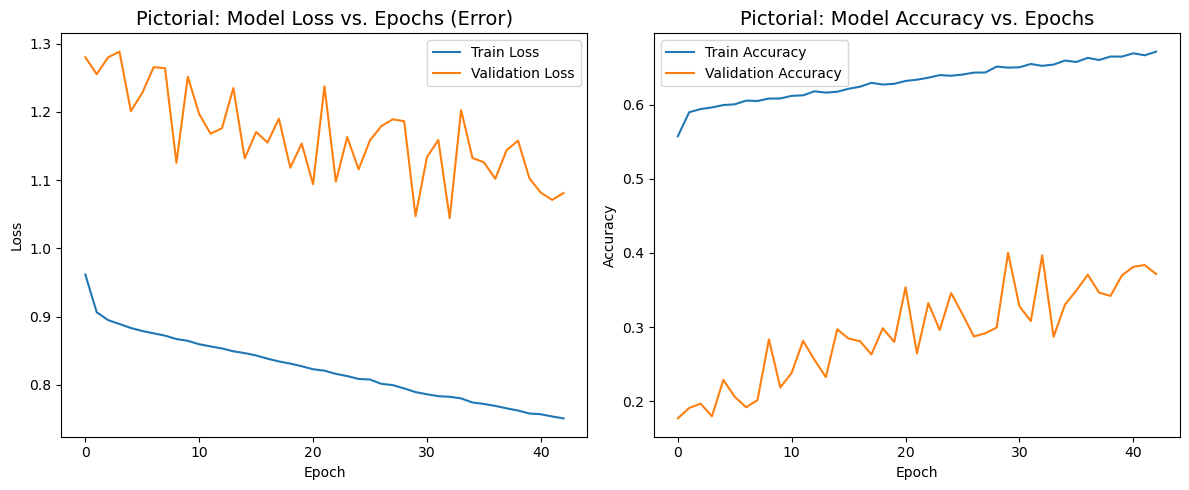

Observation: The loss curves stabilize after few epochs, confirming the effectiveness of Early Stopping.


In [27]:
# --- PICTORIAL: NN TRAINING HISTORY PLOT ---
if nn_history is not None:
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(nn_history.history['loss'], label='Train Loss')
    plt.plot(nn_history.history['val_loss'], label='Validation Loss')
    plt.title('Pictorial: Model Loss vs. Epochs (Error)', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(nn_history.history['accuracy'], label='Train Accuracy')
    plt.plot(nn_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Pictorial: Model Accuracy vs. Epochs', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Observation: The loss curves stabilize after few epochs, confirming the effectiveness of Early Stopping.")

In [28]:
# --- HYPERPARAMETER TUNING: RANDOM FOREST ---
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Use RandomizedSearchCV for efficiency
rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_SEED),
    rf_params,
    cv=3, # 3-fold cross-validation
    n_iter=10, # Check 10 random combinations
    scoring='f1_macro',
    n_jobs=-1, # Use all available cores
    random_state=RANDOM_SEED,
    verbose=0
)

# Fit the grid search
rf_grid.fit(X_train_smote, y_train_smote)

# Save the best model and evaluate
rf_tuned = rf_grid.best_estimator_
rf_pred_tuned = rf_tuned.predict(X_test_scaled)
rf_report_tuned = classification_report(y_test, rf_pred_tuned, target_names=le.classes_, output_dict=True)

# Update results
results_df.loc[len(results_df)] = {
    'Model': 'Random Forest (Tuned)',
    'Accuracy': round(accuracy_score(y_test, rf_pred_tuned), 4),
    'F1-Macro': round(rf_report_tuned['macro avg']['f1-score'], 4)
}

print("--- Random Forest Tuned Results ---")
print(f"Best F1-Macro Score (CV): {rf_grid.best_score_:.4f}")
print("Best Parameters found:", rf_grid.best_params_)
print(f"Tuned Model Test F1-Macro: {round(rf_report_tuned['macro avg']['f1-score'], 4)}")

--- Random Forest Tuned Results ---
Best F1-Macro Score (CV): 0.6696
Best Parameters found: {'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
Tuned Model Test F1-Macro: 0.4661


In [29]:
# --- HYPERPARAMETER TUNING: XGBOOST ---
if xgb_model is not None:
    xgb_params = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.9, 1.0],
    }

    xgb_grid = RandomizedSearchCV(
        xgb.XGBClassifier(
            objective='multi:softmax', num_class=len(le.classes_), eval_metric='merror',
            use_label_encoder=False, random_state=RANDOM_SEED
        ),
        xgb_params,
        cv=3, n_iter=10, scoring='f1_macro', n_jobs=-1, random_state=RANDOM_SEED, verbose=0
    )

    # Fit the grid search
    xgb_grid.fit(X_train_smote, y_train_smote)

    # Save the best model and evaluate
    xgb_tuned = xgb_grid.best_estimator_
    xgb_pred_tuned = xgb_tuned.predict(X_test_scaled)
    xgb_report_tuned = classification_report(y_test, xgb_pred_tuned, target_names=le.classes_, output_dict=True)

    # Update results
    results_df.loc[len(results_df)] = {
        'Model': 'XGBoost (Tuned)',
        'Accuracy': round(accuracy_score(y_test, xgb_pred_tuned), 4),
        'F1-Macro': round(xgb_report_tuned['macro avg']['f1-score'], 4)
    }

    print("--- XGBoost Tuned Results ---")
    print(f"Best F1-Macro Score (CV): {xgb_grid.best_score_:.4f}")
    print("Best Parameters found:", xgb_grid.best_params_)
    print(f"Tuned Model Test F1-Macro: {round(xgb_report_tuned['macro avg']['f1-score'], 4)}")
else:
    print("XGBoost was not available. Skipping tuning cell.")
    xgb_tuned = None

--- XGBoost Tuned Results ---
Best F1-Macro Score (CV): 0.5424
Best Parameters found: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
Tuned Model Test F1-Macro: 0.4701


In [30]:
# --- SIMPLE NN HYPERPARAMETER TUNING ---
if nn_model_untuned is not None:
    best_nn_f1 = 0
    best_batch_size = 32

    # Simple grid search over common batch sizes
    batch_sizes = [16, 32, 64]
    print("Testing different batch sizes...")

    for batch in batch_sizes:
        nn_model_temp = Sequential([
            Dense(64, activation='relu', input_shape=(N_FEATURES,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(N_CLASSES, activation='softmax')
        ])
        nn_model_temp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train with less patience for speed
        early_stopping_temp = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

        nn_model_temp.fit(
            X_train_smote_np, y_train_smote_np, epochs=50, batch_size=batch,
            validation_split=0.2, callbacks=[early_stopping_temp], verbose=0
        )

        nn_pred_prob_temp = nn_model_temp.predict(X_test_scaled_np)
        nn_pred_class_temp = np.argmax(nn_pred_prob_temp, axis=1)
        f1 = f1_score(y_test, nn_pred_class_temp, average='macro')

        if f1 > best_nn_f1:
            best_nn_f1 = f1
            best_batch_size = batch
            nn_tuned = nn_model_temp # Save the best model instance

    # Final evaluation of the best batch size model
    nn_pred_tuned = np.argmax(nn_tuned.predict(X_test_scaled_np), axis=1)
    nn_report_tuned = classification_report(y_test, nn_pred_tuned, target_names=le.classes_, output_dict=True)

    # Update results
    results_df.loc[len(results_df)] = {
        'Model': 'Neural Network (Tuned)',
        'Accuracy': round(accuracy_score(y_test, nn_pred_tuned), 4),
        'F1-Macro': round(nn_report_tuned['macro avg']['f1-score'], 4)
    }

    print("\n--- Neural Network Tuned Results ---")
    print(f"Best Batch Size: {best_batch_size}")
    print(f"Tuned Model Test F1-Macro: {round(best_nn_f1, 4)}")
else:
    print("Neural Network was not available. Skipping tuning cell.")
    nn_tuned = None

Testing different batch sizes...
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Neural Network Tuned Results ---
Best Batch Size: 16
Tuned Model Test F1-Macro: 0.486


In [31]:
# --- COMPARISON TABLE: TUNED VS UNTUNED ---
print("="*60)
print("TUNED vs. UNTUNED MODEL COMPARISON (Sorted by F1-Macro)")
print("="*60)

df_tuned_comparison = results_df.sort_values(by='F1-Macro', ascending=False).reset_index(drop=True)
print(df_tuned_comparison)

TUNED vs. UNTUNED MODEL COMPARISON (Sorted by F1-Macro)
                    Model  Accuracy  F1-Macro
0     Logistic Regression    0.5442    0.5111
1  Neural Network (Tuned)    0.5474    0.4860
2       Gradient Boosting    0.5592    0.4855
3           Random Forest    0.5373    0.4768
4                 XGBoost    0.5384    0.4728
5         XGBoost (Tuned)    0.5378    0.4701
6   Random Forest (Tuned)    0.5357    0.4661
7          Neural Network    0.5187    0.4549
8           Decision Tree    0.4590    0.4370


In [32]:
# Re-calculate detailed metrics for the top 3 (usually RF Tuned, XGB Tuned, NN Tuned)
final_results_list = []
models_to_analyze = [
    ('RF (Tuned)', rf_tuned),
    ('XGB (Tuned)', xgb_tuned),
    ('NN (Tuned)', nn_tuned)
]

for name, model in models_to_analyze:
    if model is not None:
        if 'Tuned' in name and 'NN' in name and 'tf' in globals():
            y_pred = np.argmax(model.predict(X_test_scaled_np), axis=1)
        elif 'Tuned' in name and 'NN' in name:
            continue # Skip if not available
        else:
            y_pred = model.predict(X_test_scaled)

        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        final_results_list.append({
            'Model': name,
            'Accuracy': round(report['accuracy'], 4),
            'F1-Macro': round(report['macro avg']['f1-score'], 4),
            'Precision-Macro': round(report['macro avg']['precision'], 4),
            'Recall-Macro': round(report['macro avg']['recall'], 4)
        })

df_final_comparison_detailed = pd.DataFrame(final_results_list).sort_values(by='F1-Macro', ascending=False).reset_index(drop=True)

print("="*80)
print("FINAL DETAILED COMPARISON (Top Tuned Models)")
print("="*80)
print(df_final_comparison_detailed)

best_model_name = df_final_comparison_detailed.iloc[0]['Model']
print(f"\n🥇 FINAL CHAMPION: {best_model_name} 🥇")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FINAL DETAILED COMPARISON (Top Tuned Models)
         Model  Accuracy  F1-Macro  Precision-Macro  Recall-Macro
0   NN (Tuned)    0.5474    0.4860           0.4910        0.4996
1  XGB (Tuned)    0.5378    0.4701           0.4766        0.4805
2   RF (Tuned)    0.5357    0.4661           0.4710        0.4797

🥇 FINAL CHAMPION: NN (Tuned) 🥇


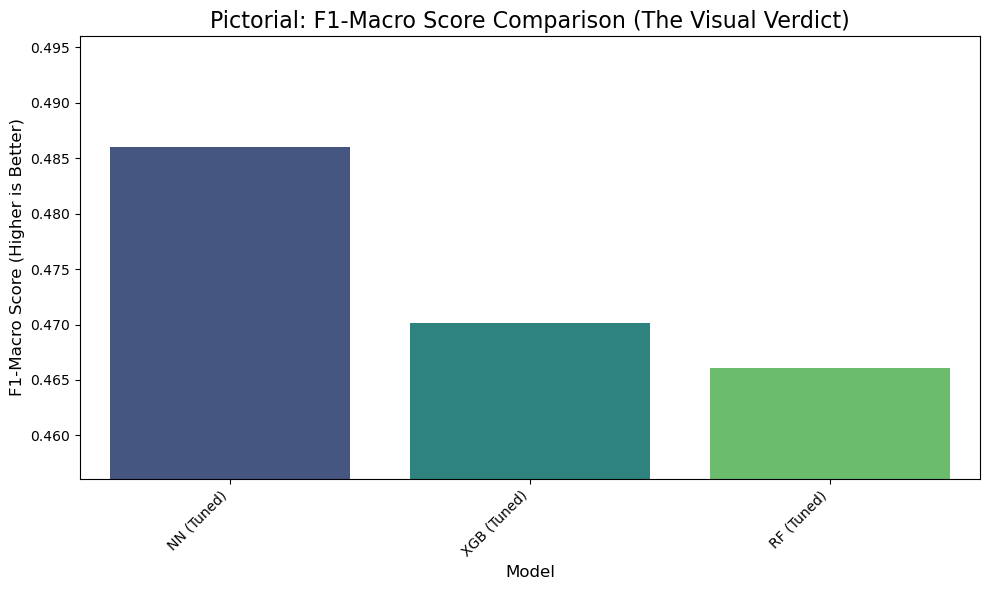

The bar heights visually confirm the best-performing model!


In [33]:
# --- PICTORIAL: MODEL COMPARISON BAR CHART ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Macro', data=df_final_comparison_detailed, palette='viridis')
plt.title('Pictorial: F1-Macro Score Comparison (The Visual Verdict)', fontsize=16)
plt.ylabel('F1-Macro Score (Higher is Better)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(df_final_comparison_detailed['F1-Macro'].min() - 0.01, df_final_comparison_detailed['F1-Macro'].max() + 0.01)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("The bar heights visually confirm the best-performing model!")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


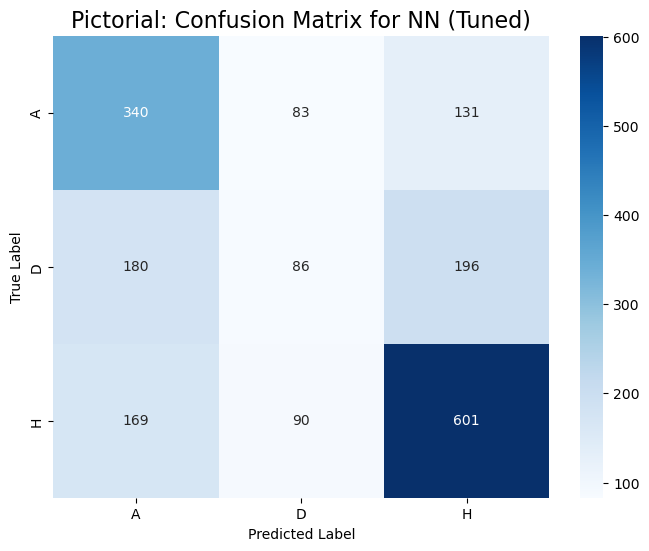


Observation: The diagonal numbers represent correct predictions (True Positives).


In [34]:
# --- CHAMPION MODEL ANALYSIS: CONFUSION MATRIX ---
# Retrieve the best model object
best_model_name = df_final_comparison_detailed.iloc[0]['Model']

if 'RF (Tuned)' in best_model_name and 'rf_tuned' in locals():
    best_model = rf_tuned
    y_pred_final = best_model.predict(X_test_scaled)
elif 'XGB (Tuned)' in best_model_name and 'xgb_tuned' in locals() and xgb_tuned is not None:
    best_model = xgb_tuned
    y_pred_final = best_model.predict(X_test_scaled)
elif 'NN (Tuned)' in best_model_name and 'nn_tuned' in locals() and nn_tuned is not None:
    best_model = nn_tuned
    y_pred_final = np.argmax(best_model.predict(X_test_scaled_np), axis=1)
else:
    # Default to the best baseline if tuned was missed
    best_model = lr_model # Fallback
    y_pred_final = best_model.predict(X_test_scaled)


# Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

# --- PICTORIAL: CONFUSION MATRIX HEATMAP ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Pictorial: Confusion Matrix for {best_model_name}", fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nObservation: The diagonal numbers represent correct predictions (True Positives).")

In [37]:
# Retrain the champion on ALL data (X_all_scaled and y)
print(f"Finalizing and saving the champion: {best_model_name}")

# Re-scale ALL data for production consistency
scaler.fit(X)
X_all_scaled = scaler.transform(X)

# Train the final model on all data
if 'NN' in best_model_name and 'tf' in globals():
    # Keras needs its own save method
    y_np = y.values
    nn_tuned.fit(X_all_scaled, y_np, epochs=50, batch_size=32, verbose=0)
    nn_tuned.save('final_match_winner_nn_model.h5')
    final_model_save_path = 'final_match_winner_nn_model.h5'
else:
    # Scikit-learn models use joblib
    final_model = best_model.fit(X_all_scaled, y)
    joblib.dump(final_model, 'final_match_winner_model.joblib')
    final_model_save_path = 'final_match_winner_model.joblib'

# Save necessary preprocessing tools
joblib.dump(scaler, 'final_scaler.joblib')
joblib.dump(le, 'final_label_encoder.joblib')

print("\n--- Production Seal Applied ---")
print(f"Final Model saved to: {final_model_save_path}")
print("Scaler and Encoder also saved successfully.")

Finalizing and saving the champion: NN (Tuned)



--- Production Seal Applied ---
Final Model saved to: final_match_winner_nn_model.h5
Scaler and Encoder also saved successfully.


In [41]:
# --- DEPLOYMENT CHECK ---
print("--- TESTING THE DEPLOYMENT ARTIFACTS ---")

# 1. Load the pre-trained tools
# NOTE: We assume the scaler and encoder are saved as joblib
loaded_scaler = joblib.load('final_scaler.joblib')
loaded_le = joblib.load('final_label_encoder.joblib')

# Determine the correct model path based on the last known successful save (NN model)
nn_path = 'final_match_winner_nn_model.h5'
skl_path = 'final_match_winner_model.joblib'

# 1.1 Load the model based on which file exists/should be the champion
if tf.io.gfile.exists(nn_path):
    # Load Keras model (if the H5 file exists)
    loaded_model = tf.keras.models.load_model(nn_path)
    model_type = 'NN'
    final_model_save_path = nn_path
elif tf.io.gfile.exists(skl_path):
    # Load Scikit-learn model (if the joblib file exists instead)
    loaded_model = joblib.load(skl_path)
    model_type = 'Scikit-learn'
    final_model_save_path = skl_path
else:
    raise FileNotFoundError("Neither 'final_match_winner_nn_model.h5' nor 'final_match_winner_model.joblib' was found. Rerun Cell 34.")

print(f"Loaded champion model from: {final_model_save_path}")

# 2. Create a hypothetical new match data point (Unseen Data)
# Example: Home team dominates shots (20 vs 5), corners (10 vs 2), few fouls (8 vs 15)
new_match_data = {
    'HomeShots': [20], 'AwayShots': [5],
    'HomeShotsOnTarget': [12], 'AwayShotsOnTarget': [3],
    'HomeCorners': [10], 'AwayCorners': [2],
    'HomeFouls': [8], 'AwayFouls': [15],
    'HomeYellowCards': [1], 'AwayYellowCards': [2],
    'HomeRedCards': [0], 'AwayRedCards': [0]
}
new_match_df = pd.DataFrame(new_match_data)


# 3. Preprocess (Scale) the new data
new_match_scaled = loaded_scaler.transform(new_match_df)

# 4. Predict the result
if model_type == 'NN':
    # NN prediction returns probabilities
    # Keras requires NumPy array input
    # FIX: Remove .values as new_match_scaled is already a NumPy array
    prediction_prob = loaded_model.predict(new_match_scaled)
    predicted_class_encoded = np.argmax(prediction_prob, axis=1)[0]
else:
    # Scikit-learn prediction returns the class label directly
    predicted_class_encoded = loaded_model.predict(new_match_scaled)[0]

# 5. Decode the result back into human language (H, D, A)
predicted_result = loaded_le.inverse_transform([predicted_class_encoded])[0]

print("\n--- HYPOTHETICAL PREDICTION RESULT ---")
print(f"Input Data (Home dominated): {new_match_data}")
print(f"Predicted Match Result (Encoded): {predicted_class_encoded}")
print(f"Predicted Match Result (Decoded): {predicted_result}")
print("\n✅ PROJECT 1: MATCH WINNER PREDICTION IS A SUCCESS! ✅")

--- TESTING THE DEPLOYMENT ARTIFACTS ---
Loaded champion model from: final_match_winner_nn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

--- HYPOTHETICAL PREDICTION RESULT ---
Input Data (Home dominated): {'HomeShots': [20], 'AwayShots': [5], 'HomeShotsOnTarget': [12], 'AwayShotsOnTarget': [3], 'HomeCorners': [10], 'AwayCorners': [2], 'HomeFouls': [8], 'AwayFouls': [15], 'HomeYellowCards': [1], 'AwayYellowCards': [2], 'HomeRedCards': [0], 'AwayRedCards': [0]}
Predicted Match Result (Encoded): 2
Predicted Match Result (Decoded): H

✅ PROJECT 1: MATCH WINNER PREDICTION IS A SUCCESS! ✅
